# Cycling Power Predictions II: Physics-Inspired Feature Engineering

[In my first attempt](https://cyclo-analytics.com/2017/11/13/predicting-power-without-a-power-meter/), I set out to see how accurately you could predict your power output during cycling from features such as cadence, speed and heartrate. I extracted the data from roughly 50 of my previous ride files, during which I used a PowerTap Hub to measure my true power output. I also measured my speed, elevation, heartrate and cadence through other devices. 

I carried out some basic feature engineering in order to create variables such as change in heartrate, change in speed, and the steepness of the road. I fitted numerous models to the data and compared their results. By comparing the feature importances generated from the Random Forest model, the most important variables turned out to the be the un-engineered cadence and heartrate.  

<img src="featureImportances.png" alt="FeatureImportances" style="width: 600px;"/>

## Physics-Inspired Features

The question I want to answer here is can we improve on our feature engineering? More specifically, can we use the physical equations of motion to improve how we construct features. I mentioned in the [first attempt](https://cyclo-analytics.com/2017/11/13/predicting-power-without-a-power-meter/) that Strava provides a power estimate based on simple physical assumptions - this estimates your power output by simply balancing all the relevant forces that act on you as a cyclist. Let's begin with the famous equation that states that the net force acting on a body $\mathbf{F_{net}}$ equals the mass $\mathbf{m}$ times the acceleration $\mathbf{a}$,

$$\mathbf{ F_{net} = ma }. $$

We can now write the net force $\mathbf{F_{net}}$ as the sum of the individual forces that act on a cyclist as the following

$$ \mathbf{ F_{net} = F_{output} - F_{air} - F_{grav} - F_{rolling} - F_{brake} },$$

where $\mathbf{F_{output}}$ is the force being output by the cyclist (which is what we're trying to predict), $\mathbf{F_{grav}}$ is the force of gravity (this can be positive or negative depending on whether we're going up or downhill), $\mathbf{F_{air}}$ is aerodynamic drag, $\mathbf{F_{rolling}}$ is the rolling resistance between the tyres and road, and finally $\mathbf{F_{brake}}$ is the force of the cyclist applying the brakes. 

We now want to write down physical equations for each force. The rolling resistance will not vary much during a ride so we will ignore this term, and we cannot predict when a cyclist will brake either so this term will also be excluded. That leaves us with the aerodynamic drag and the force of gravity. The force caused by aerodynamic drag has the following equation

$$ \mathbf{ F_{air} = \frac{1}{2} C_d A \rho v^2 }, $$

where $\mathbf{C_d}$ is the coefficient of drag (i.e. how much drag the wind creates per unit area), $\mathbf{A}$ is the cyclists total frontal area that the wind 'sees', $\mathbf{\rho}$ is the density of air, and $\mathbf{v}$ is the speed of the cyclist. The drag coefficient multpliplied by the frontal area produces the total aerodynamic drag '$\mathbf{C_dA}$' which cyclists are obsessed with reducing. The equation for the gravitational term is given by

$$ \mathbf{ F_{grav} = m g \text{sin}(\theta) } $$,

where $\mathbf{m}$ is the total mass of the cyclist plus the bike, $\mathbf{g = 9.81}$ is the gravitational acceleration,  and $\mathbf{\theta}$ is the angle of the road relative to a flat surface ($\mathbf{\theta = 0}$ is completely flat, while $\mathbf{\theta=90}$ degrees is a vertical wall). We now have formulas for the force of aerodynamic drag and gravity, but we're interested in predicting the *power* generated by the cyclist, not the force. This is an important difference as power is the energy generated/work done, due to a force, per second. In order to convert the above force terms to power, we simply multiply by the speed, leading to

$$ \mathbf{ P_{air} = \frac{1}{2} C_d A \rho v^3 }, $$
$$ \mathbf{ P_{grav} = m g \text{sin}(\theta) v }. $$

These terms tells us how aerodynamic drag and gravity contribute to the kinetic energy change of the cyclist. Ignoring the constants, we can see that these two power terms are proportional to the following quantities

$$ \mathbf{ P_{air} \propto (\text{speed})^3 }, $$
$$ \mathbf{ P_{grav} \propto \text{gradient}\times\text{speed} }, $$

where we have assumed $\mathbf{ \text{sin}(\theta) \approx \text{tan}(\theta) = \text{gradient} }$, which is not a bad approximation as changes in elevation are small compared to changes in horizontal distance. These two quantities, $\mathbf{(\text{speed})^3}$ and $\mathbf{\text{gradient}\times\text{speed}}$, are good candidates for features as they tell us how the power demands of the cyclist change in time. The speed data is a stored variable in the .fit files,  and we can easily calculate the gradient. 

One problem with these two new features is that although the wind and gradient may change, this does not necessarily mean the cyclist will increase or decrease their power. For example when going downhill, most cyclists will reduce their power output and freewheel, even though the wind resistance has increased dramatically. To try and make an even better feature, let's consider the balance of all the power terms (ignoring rolling resistance)

$$ \mathbf{ mav = P_{output} - P_{air} + P_{grav} },$$

which is $ \mathbf{ F_{net} = ma } $ multiplied by the speed $\mathbf{v}$. Rearrange for $ \mathbf{ P_{output} } $ and then substitute our equations for $\mathbf{P_{air}}$ and $\mathbf{P_{grav}}$, giving

$$ \mathbf{ P_{output} = mav + \frac{1}{2} C_d A \rho v^3 - m g \text{sin}(\theta) v }. $$

This gives us a rough estimate of the cyclists power output by balancing the dominant forces. This should hopefully form a better feature than $\mathbf{(\text{speed})^3}$ and $\mathbf{\text{gradient}\times\text{speed}}$ as it should more accurately track changes in the true power output of the cyclist. We'll use in the ballpark values for our parameteters: $m=80$ kg, $C_d A = 0.3$ m$^2$,  $\rho = 1.225$ kgm$^3$. The remaining variables speed, gradient and acceleration can be calculated from the ride data.

We now have three new features to add to our dataset:

New Feature | Equation | Physical Origin
:---:|:--------------------------------------------------------:|:-------------------------
1 | $\mathbf{v^3}$ | Proportional to wind power
2 | $\mathbf{\text{sin}(\theta) v}$ | Proportional to gravitational power
3 | $\mathbf{mav + \frac{1}{2} C_d A \rho v^3 + m g \text{sin}(\theta) v }$ | Rough estimate of cyclists power output


## Load Data and Preprocess

We now want to see if using these three new features improves the accuracy of our models. In order to compare the results from my first attempt, I'll use the exact same models with the exact parameters, but this time we'll introduce the three new features above in addition to the original features used previously. The only model change I will make is to introduce three more hidden units in each hidden layer of the neural network; this ensures that the number of hidden units is one more than the number of features. 

The dataset is formed using the functions defined in the python script titled 'dataPrep2.py', which can be found in the GitHub repository for this post. The data is extracted from the .fit files and saved as a numpy array. Let's now load this data.

In [28]:
import numpy as np

from dataPrep2 import loadDataset2

xTrain, yTrain, xTest, yTest = loadDataset2()

print "Total number of observations: ", xTrain.shape[0]+xTest.shape[0]
print "       Training observations: ", xTrain.shape[0]
print "           Test observations: ", xTest.shape[0]
print "\n Number of inputs/features: ", xTrain.shape[1]
print " Number of outputs/targets: ", 1

Total number of observations:  177330
       Training observations:  137208
           Test observations:  40122

 Number of inputs/features:  9
 Number of outputs/targets:  1


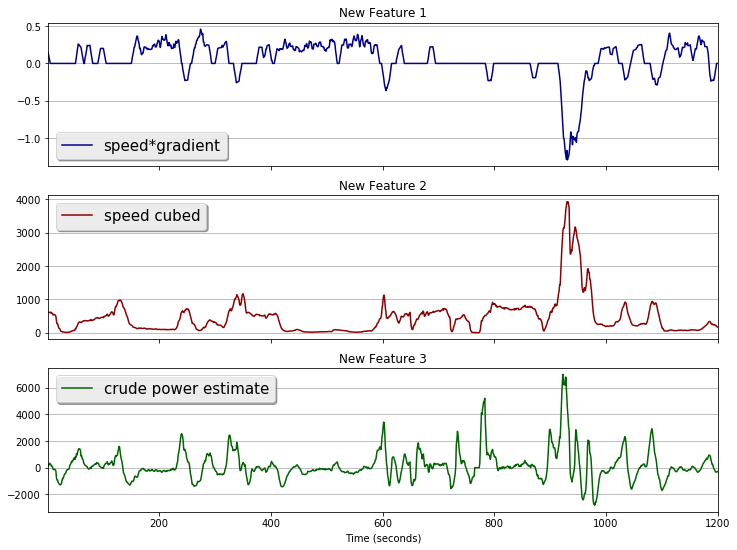

In [29]:
# plot 20 minutes of data of our 3 new features

import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax0,ax1,ax2) = plt.subplots(3,1,sharex=True)
t = np.linspace(1,1200,1200)

ax0.plot( t, xTrain[-1200:,-3], color='darkblue', label='speed*gradient' )
ax0.set_xlim( (1,1200) )
ax0.yaxis.grid(True)
ax0.legend( shadow=True, loc=3, fontsize=15 )
ax0.set_title('New Feature 1')

ax1.plot( t, xTrain[-1200:,-2], color='darkred', label='speed cubed' )
ax1.set_xlim( (1,1200) )
ax1.yaxis.grid(True)
ax1.legend( shadow=True, loc=2, fontsize=15 )
ax1.set_title('New Feature 2')

ax2.plot( t, xTrain[-1200:,-1], color='darkgreen', label='crude power estimate')
ax2.set_xlim( (1,1200) )
ax2.yaxis.grid(True)
ax2.legend( shadow=True, loc=2, fontsize=15 )
ax2.set_title('New Feature 3')
ax2.set_xlabel('Time (seconds)')

fig.set_size_inches( (12,9) )

plt.show()

It can be seen in the third feature, the estimate of the cyclists power based on simple physical assumptions, has unrealistic positive spikes (I'd like to see any cyclist put out over 6000 watts). The power also drops below zero at points; this may be due to the fact that we are ignoring rolling resistance and any braking that might occurs. If a cyclist applies the brakes, this estimate might interpret the resulting deceleration as the cyclist applying negative power. 

These issues however do not matter too much. We're using this power estimate as a feature to increase the amount of information we have on the variability of the true power output by the cyclist. The power estimate feature doesn't have to be physically consistent, it simply has to contain potentially useful information. 

Before training our models, we'll clean up and standardise our data as before.

In [30]:
# Remove NaNs and standardise data

from sklearn.preprocessing import Imputer, StandardScaler

# convert all infinite values to nans
xTrain[ np.isinf( xTrain ) ] = np.nan
xTest[ np.isinf( xTest ) ] = np.nan

# construct imputer and scaler
myImputer = Imputer( missing_values='NaN', strategy='median', axis=0 )
myScaler = StandardScaler()

# impute NaNs
xTrain = myImputer.fit_transform( xTrain )
xTest = myImputer.transform( xTest )

# remove mean and divide by standard deviation
xTrain = myScaler.fit_transform( xTrain )
xTest = myScaler.transform( xTest )

## Construct and Train Models

Use the same models as before:

* Multiple Linear Regression.
* K-Nearest Neighbour Regressor.
* Random Forest Regressor.
* Multi-Layer Perceptron Regressor.

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# model names
modelNames = [ 'Linear Regression', 'K-Nearest', 'Random Forest', 'Neural Network' ]

# construct models
modelList =  [ LinearRegression(),
               KNeighborsRegressor( n_neighbors=75 ),
               RandomForestRegressor( n_estimators=500, n_jobs=3 ),
               MLPRegressor( hidden_layer_sizes=(10,10), learning_rate_init=0.001, 
                            alpha=0.0, max_iter=1000, tol=0.0 )
             ]

# train each model
for model in modelList:
    
    print "\nCurrently training:\n\t", model, "\n"
    model.fit( xTrain, yTrain )
    print "Done!"


Currently training:
	LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False) 

Done!

Currently training:
	KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=75, p=2,
          weights='uniform') 

Done!

Currently training:
	RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=3,
           oob_score=False, random_state=None, verbose=0, warm_start=False) 

Done!

Currently training:
	MLPRegressor(activation='relu', alpha=0.0, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       ne

## Model Evaluation

Previously we used the coefficient of determination $R^2$ to compare our models. The $R^2$ score equals one for perfect predictions, zero for simply using the average power value, and negative values for really bad models. The original scores we are trying to improve on are listed below.

| Model | $R^2$ Score |
|:---:|:---:|
| Multiple Linear Regression | 0.0614  |
| K-Nearest Neigbour | 0.0929 |
| Random Forest | 0.0913 |
| Neural Network | 0.0945 |

Let's see if these scores change by introducing our three new physics-inspired features.

In [32]:
# loop through each model and calculate the score
for i, model in enumerate( modelList ) :
    
    print modelNames[i], ":", np.round( model.score( xTest, yTest ), 4 )

Linear Regression : 0.0633
K-Nearest : 0.0924
Random Forest : 0.0928
Neural Network : 0.0958


We do see some modest improvements and the linear regression improved the most. This is likely due to the fact that the new features are nonlinear functions of the original data, such that the linear model is now regressing onto features which vary more linearly with the true power. This increases the linear models predictive power.

The K-Nearest Neighbour model score decreases slightly. The performance of a K-Nearest Neighbour model generally decreases as the number of features grows larger; this is because notions of similarity/distance between data points distort in a high-dimensional space. The decrease in score however is small and may not be statistically significant, so we should be refrain from over-interpreting such changes.

Both the Random Forest and Neural Network model scores increase, and this likely due to an increased amount of information being supplied to the models by the new features. Why not form every conceivable combination of the original features and feed them in too? This would increase the amount of information the models can utilise and therefore lead to more accurate predictions. Their are a few issues with this method. First, this would dramatically increase the computational cost of training these models, potentially making the training intractable. Second, if the number of features becomes comparable to the number of training examples, you're at risk of overfitting and will then have to employ some form of regularisation. Third, you may lose some interpretability of your features if you start making increasingly more complex functions of the original features (this however may not be an issue depending on the goal of the project).

Finally, lets look at the feature importances generated by the Random Forest and see how these new features compare to each other with regards to predictive skill.

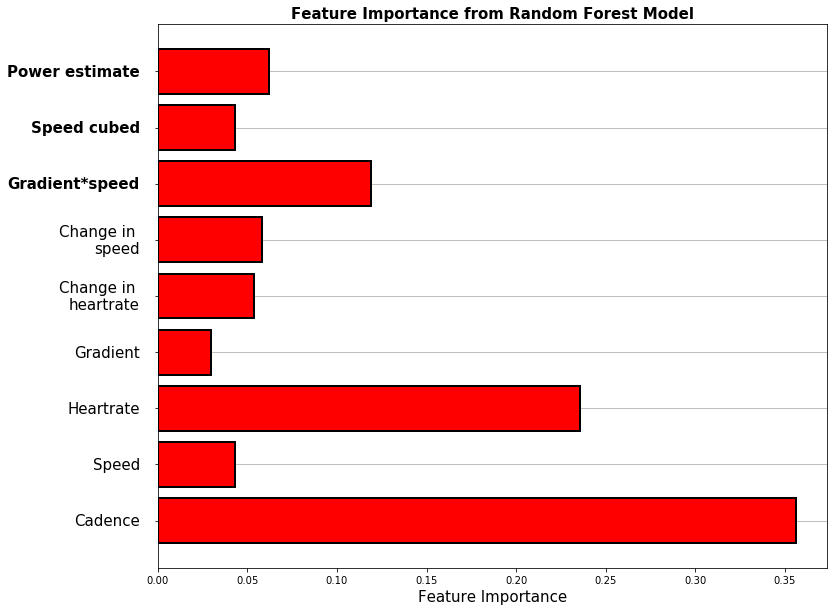

In [33]:
# extract feature importances from random forest model
featImpo = modelList[2].feature_importances_

# make list of feature names
features = [ 'Cadence', 'Speed', 'Heartrate', 
            'Gradient', 'Change in \nheartrate', 
            'Change in \nspeed', 'Gradient*speed',
            'Speed cubed', 'Power estimate']

# plot a bar chart
plt.barh( np.linspace(1,9,9), featImpo, color='red', edgecolor='black', linewidth=2 )

fig, ax = plt.gcf(), plt.gca()

fig.set_size_inches( (12,10) )
ax.set_xlabel( 'Feature Importance', fontsize=15 )
ax.yaxis.grid(True)
ax.yaxis.set_ticks( np.linspace(1,9,9) )
ax.yaxis.set_ticklabels([])
ax.set_axisbelow(True)
ax.set_title('Feature Importance from Random Forest Model', fontsize=15, fontweight='bold' )

# annotate
for i in range(9) :
    if i<6 :
        plt.text( -0.01, i+1, features[i], fontsize=15, va='center', ha='right' )
    else :
        plt.text( -0.01, i+1, features[i], fontsize=15, va='center', ha='right', fontweight='bold' )
    
plt.show()

Heartrate and cadence remain the most useful features, but the gradient$*$speed feature moves into third place. This is interesting as individually, gradient and speed are the least important features, while the interaction between them (their product) becomes useful. The speed cubed feature didn't turn out to be that important; despite being proportional to the aerodynamic drag, the true power output must not vary much with changes in the wind forcing. 

Which features does the linear regression rely on the most? Since all the input features have been normalised, we can directly compare the magnitude of the resulting linear regression coefficients. Let's extract them and compare them like how we have done with the above feature importances.

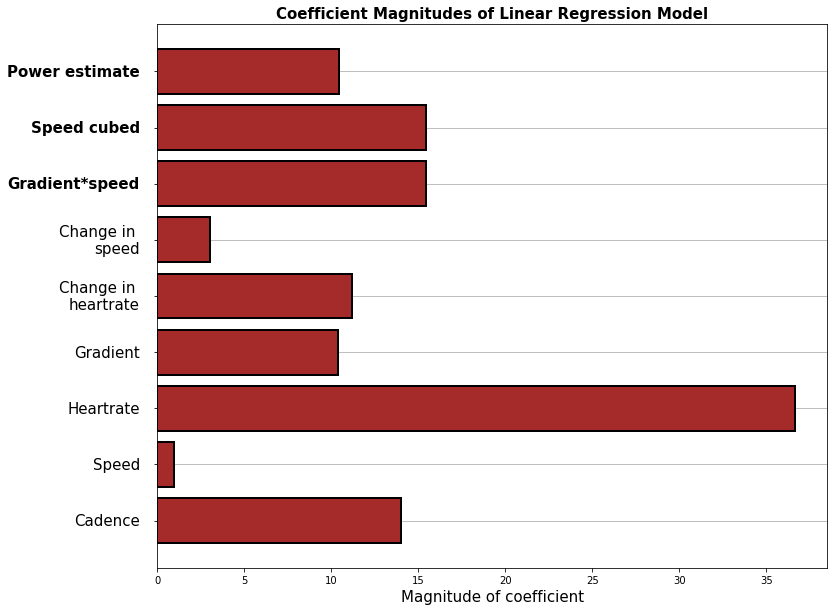

In [34]:
coef = modelList[0].coef_

# plot a bar chart
plt.barh( np.linspace(1,9,9), np.abs( coef ), color='brown', edgecolor='black', linewidth=2 )

fig, ax = plt.gcf(), plt.gca()

fig.set_size_inches( (12,10) )
ax.set_xlabel( 'Magnitude of coefficient', fontsize=15 )
ax.yaxis.grid(True)
ax.yaxis.set_ticks( np.linspace(1,9,9) )
ax.yaxis.set_ticklabels([])
ax.set_axisbelow(True)
ax.set_title('Coefficient Magnitudes of Linear Regression Model', fontsize=15, fontweight='bold' )

# annotate
for i in range(9) :
    if i<6 :
        plt.text( -1, i+1, features[i], fontsize=15, va='center', ha='right' )
    else :
        plt.text( -1, i+1, features[i], fontsize=15, va='center', ha='right', fontweight='bold' )
    
plt.show()



We see that cadence is only the fourth most important feature within the linear regression model and this makes sense; when pedalling a cyclist can exhibit a range of power values for the same cadence value, but if the cadence drops to zero, then the power *must* also drop to zero. This is a highly nonlinear relationship so it's not surprisingly the linear model can't capture that behaviour. We also see that our physics-inspired features are relatively useful within the linear regression model. 

To sum, up you can improve model performance by engineering features based on the physical equations of the system. The code for this post can be found in [this GitHub repo](https://github.com/TomBolton/powerPredictions2). Thank you to Reddit user *nickl* for suggesting looking into this type of feature engineering.